In [1]:
!pip install kagglehub --quiet

import kagglehub
import os

# تحميل البيانات من KaggleHub
path = kagglehub.dataset_download("asdasdasasdas/garbage-classification")
print("Path to dataset:", path)

# تحديد مجلد البيانات
data_dir = os.path.join(path, "Garbage classification", "Garbage classification")
print("Classes:", os.listdir(data_dir))


Path to dataset: /kaggle/input/garbage-classification
Classes: ['metal', 'glass', 'paper', 'trash', 'cardboard', 'plastic']


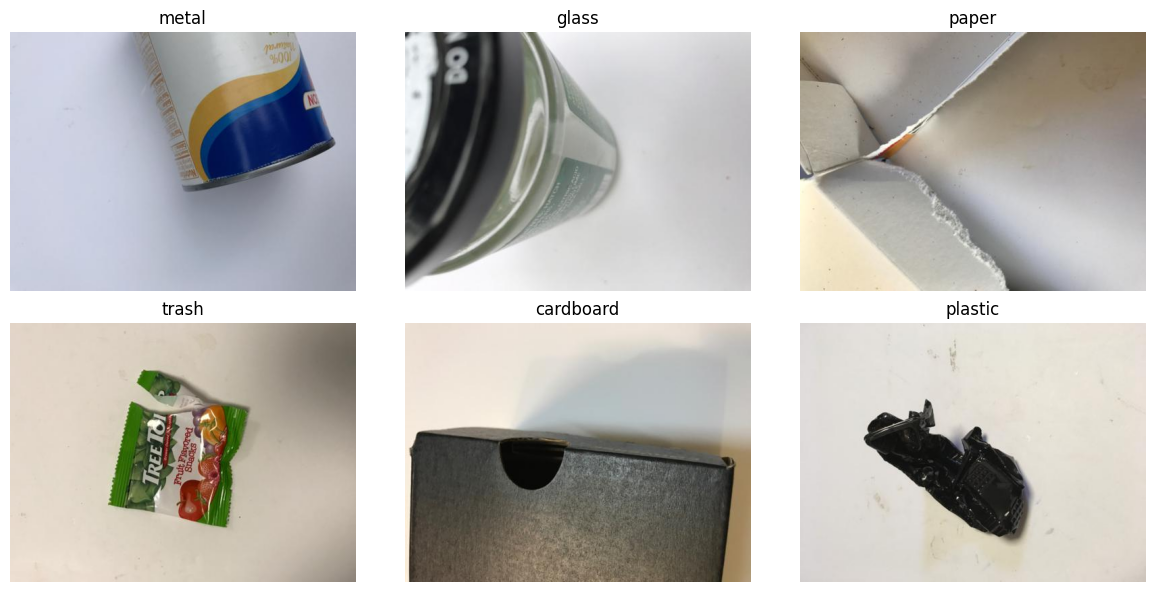

In [2]:
import matplotlib.pyplot as plt

classes = os.listdir(data_dir)
plt.figure(figsize=(12, 6))

# عرض صورة واحدة من كل فئة
for i, category in enumerate(classes):
    category_path = os.path.join(data_dir, category)
    files = os.listdir(category_path)
    image_file = next(f for f in files if not os.path.isdir(os.path.join(category_path, f)))
    img = plt.imread(os.path.join(category_path, image_file))
    plt.subplot(2, 3, i + 1)
    plt.imshow(img)
    plt.title(category)
    plt.axis("off")

plt.tight_layout()
plt.show()


In [3]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMG_SIZE = (224, 224)
BATCH_SIZE = 32

# Augmentation + Split
datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    rotation_range=25,
    zoom_range=0.2,
    brightness_range=[0.7, 1.3],
    horizontal_flip=True
)

# البيانات التدريبية
train_gen = datagen.flow_from_directory(
    data_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training',
    shuffle=True
)

# البيانات للتحقق
val_gen = datagen.flow_from_directory(
    data_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation',
    shuffle=False
)


Found 2024 images belonging to 6 classes.
Found 503 images belonging to 6 classes.


In [4]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

labels = train_gen.classes

class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(labels),
    y=labels
)

class_weight_dict = dict(enumerate(class_weights))
print("Class Weights:", class_weight_dict)


Class Weights: {0: np.float64(1.04437564499484), 1: np.float64(0.8412302576891105), 2: np.float64(1.0284552845528456), 3: np.float64(0.7086834733893558), 4: np.float64(0.8739205526770294), 5: np.float64(3.066666666666667)}


In [5]:
from tensorflow.keras import layers, models

model = models.Sequential([
    layers.Input(shape=(224, 224, 3)),

    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D(2, 2),

    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D(2, 2),

    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D(2, 2),

    layers.Conv2D(256, (3, 3), activation='relu'),
    layers.MaxPooling2D(2, 2),

    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(6, activation='softmax')
])

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 24, 24, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 12, 12, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 36864)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     9,437,440 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 6)              │         1,542 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,827,398 (37.49 MB)

 Trainable params: 9,827,398 (37.49 MB)

 Non-trainable params: 0 (0.00 B)

In [6]:
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(
    monitor='val_loss',
    patience=4,
    restore_best_weights=True,
    verbose=1
)

history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=20,
    callbacks=[early_stop],
    class_weight=class_weight_dict
)


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 313s 5s/step - accuracy: 0.2206 - loss: 1.8812 - val_accuracy: 0.3459 - val_loss: 1.5954
Epoch 2/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 304s 5s/step - accuracy: 0.3596 - loss: 1.6101 - val_accuracy: 0.3241 - val_loss: 1.6272
Epoch 3/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 302s 5s/step - accuracy: 0.3988 - loss: 1.4992 - val_accuracy: 0.3797 - val_loss: 1.5031
Epoch 4/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 302s 5s/step - accuracy: 0.4453 - loss: 1.3521 - val_accuracy: 0.4076 - val_loss: 1.6018
Epoch 5/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 303s 5s/step - accuracy: 0.4706 - loss: 1.3747 - val_accuracy: 0.3698 - val_loss: 1.4452
Epoch 6/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 301s 5s/step - accuracy: 0.4763 - loss: 1.2642 - val_accuracy: 0.4254 - val_loss: 1.4875
Epoch 7/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 322s 5s/step - accuracy: 0.5086 - loss: 1.2066 - val_accuracy: 0.4453 - val_loss: 1.3951
Epoch 8/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 317s 5s/step - accuracy: 0.4916 - loss: 1.2744 - val_accuracy: 0.3877 - v

In [7]:
loss, acc = model.evaluate(val_gen)
print(f"\nValidation Accuracy: {acc*100:.2f}%")


16/16 ━━━━━━━━━━━━━━━━━━━━ 25s 2s/step - accuracy: 0.4944 - loss: 1.3489

Validation Accuracy: 49.50%


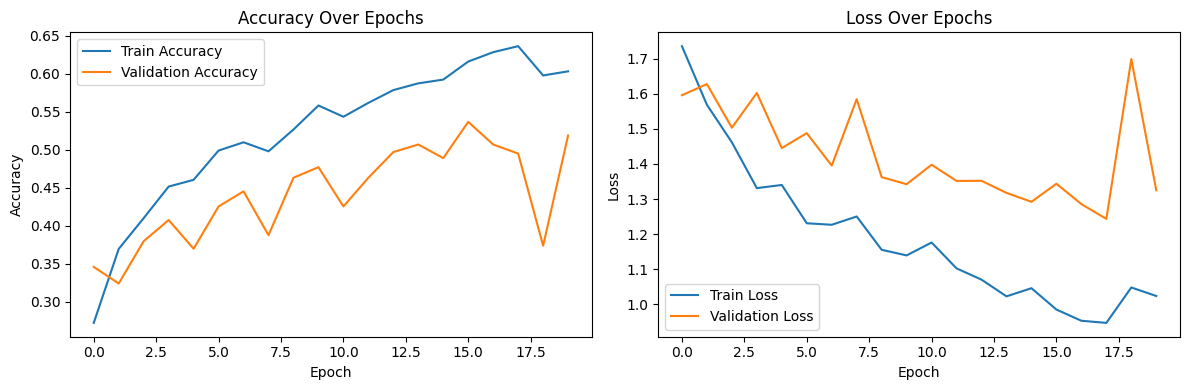

In [8]:
import matplotlib.pyplot as plt

# دقة التدريب والتحقق
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy Over Epochs')

# الخسارة
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss Over Epochs')

plt.tight_layout()
plt.show()


16/16 ━━━━━━━━━━━━━━━━━━━━ 26s 2s/step


<Figure size 1000x800 with 0 Axes>

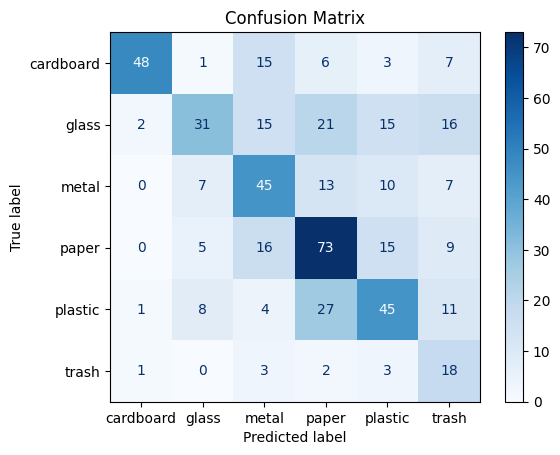

In [9]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np

# الحصول على التوقعات
y_pred_probs = model.predict(val_gen)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = val_gen.classes

# رسم المصفوفة
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=val_gen.class_indices)
plt.figure(figsize=(10, 8))
disp.plot(cmap='Blues')
plt.title("Confusion Matrix")
plt.show()


In [10]:
from sklearn.metrics import classification_report

# تقرير مفصل
print(classification_report(y_true, y_pred, target_names=val_gen.class_indices.keys()))


              precision    recall  f1-score   support

   cardboard       0.92      0.60      0.73        80
       glass       0.60      0.31      0.41       100
       metal       0.46      0.55      0.50        82
       paper       0.51      0.62      0.56       118
     plastic       0.49      0.47      0.48        96
       trash       0.26      0.67      0.38        27

    accuracy                           0.52       503
   macro avg       0.54      0.54      0.51       503
weighted avg       0.57      0.52      0.52       503



1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


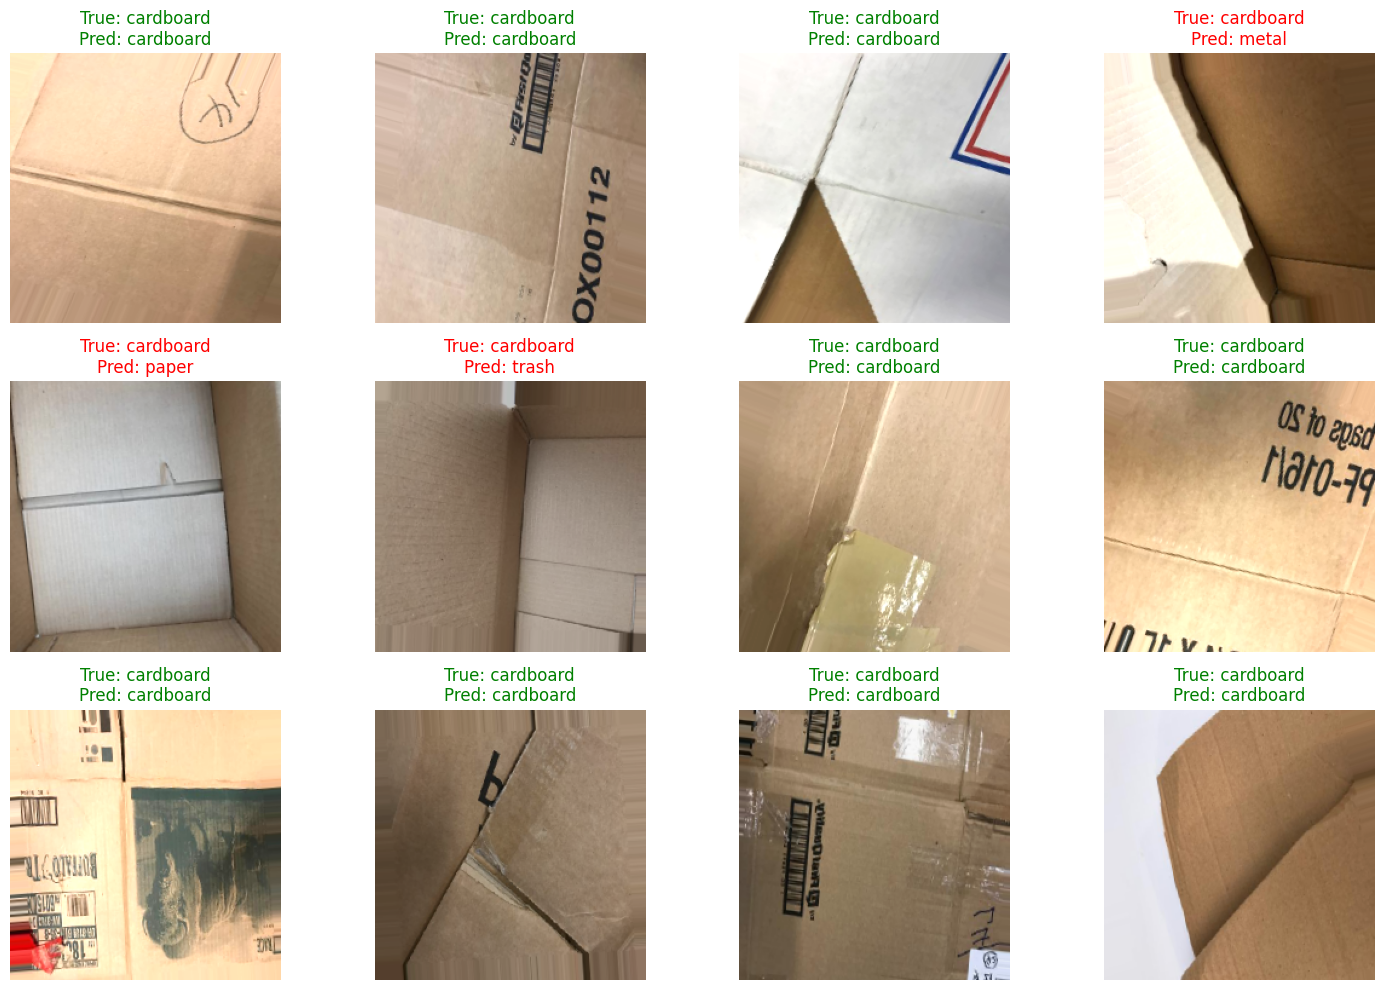

In [11]:
class_names = list(val_gen.class_indices.keys())

# إعادة تعيين المؤشر في الجنريتر
val_gen.reset()

# الحصول على بعض الصور
x_val, y_val_true = next(val_gen)
y_val_pred = model.predict(x_val)
y_val_pred_classes = np.argmax(y_val_pred, axis=1)
y_val_true_classes = np.argmax(y_val_true, axis=1)

plt.figure(figsize=(15, 10))
for i in range(12):
    plt.subplot(3, 4, i + 1)
    plt.imshow(x_val[i])
    true_label = class_names[y_val_true_classes[i]]
    pred_label = class_names[y_val_pred_classes[i]]
    color = "green" if true_label == pred_label else "red"
    plt.title(f"True: {true_label}\nPred: {pred_label}", color=color)
    plt.axis("off")

plt.tight_layout()
plt.show()


In [12]:
# حفظ النموذج بعد التدريب
model.save("garbage_classifier.keras")
print("✅ Model saved successfully as garbage_classifier.keras")


✅ Model saved successfully as garbage_classifier.keras


In [13]:
import numpy as np

# حفظ أسماء الفئات
class_names = list(train_gen.class_indices.keys())
np.save("class_names.npy", class_names)
print("✅ Class names saved as class_names.npy")


✅ Class names saved as class_names.npy


In [14]:
# حفظ النموذج بعد التدريب
model.save("garbage_classifier.keras")

# حفظ أسماء الفئات
import numpy as np
np.save("class_names.npy", class_names)


In [15]:
from google.colab import files
files.download("garbage_classifier.keras")
files.download("class_names.npy")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>